<img src="images/banner.png" alt="Folded outcrop" />

## Imports

In [1]:
from LoopStructural import GeologicalModel
from LoopStructural.datasets import load_noddy_single_fold
from LoopStructural.visualisation.model_visualisation import LavaVuModelViewer
from LoopStructural.utils.helper import strike_dip_vector, plunge_and_plunge_dir_to_vector
import pandas as pd
import numpy as np
from scipy.interpolate import Rbf
import matplotlib.pyplot as plt

In [2]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

## Modelling folds
This tutorial will show how Loop Structural improves the modelling of folds by using an accurate parameterization of folds geometry. This will be done by:
1.	Modelling folded surfaces without structural geology, i.e. using only data points and adjusting the scalar fields to those points.
2.	Modelling folds using structural geology, which includes:
    * Description of local fold frame and rotation angles calculation
    * Construction of folded foliations using fold geostatistics inside the fold frame coordinate system


## Structural geology of folds 

Folds are one of the most common features found in deformed rocks and are defined by the location of higher curvature. 
The geometry of the folded surface can be characterised by three geometrical elements: 

1. the fold hinge is the point of maximum curvature along folded surface
2. the axial surface is a surfaces that passes through all curvature points in all folded foliations
3. the fold axis is the intersection of the folded foliation and the axial surface

Modelling folded surfaces using standard implicit algorithms is challenging because the implicit modelling methods are generally trying to minimise the resulting curvature of the surface. 
To model folded surfaces the geologist will need to characterise the geometry of the folded surface in high detail.

<img src="images/folded_surface.png" alt="Folded outcrop" style="width: 400px;"/>

## Modelling folded surfaces without structural geology
In the following section we will attempt to model a synthetic fold shape that is defined by a sinusoidal folded surface.
For simplicity we will consider the fold as cylindrical and therefore only consider the fold in a 2D plane. 
The data set has been sampled from a model generated using Noddy and represents a fold with a wavelength of ~10km and amplitude of ~2km.

<img src="images/noddy.png" alt="Noddy Model" style="width: 400px;"/>

The orientation of the structure has been sampled within the model volume (10km,7km,5km) at 500m intervals. 


**The aim of this exercise is to investigate how standard implicit modelling techniques are fundamentally limited when trying to model folded surfaces.**

1. Load data from sample datasets
2.  Visualise data
3. Look at varying degrees of sampling e.g. 200 points, 100 points, 10 points. 
2. Look at using data points ONLY from a map surface


### Modelling folded surfaces using loop structural

In [3]:
# load the sample data
data, boundary_points = load_noddy_single_fold()
data.head()


,X,Y,Z,dip,strike,type,coord,random
972,500.0,500.0,5500.0,69.965373,399.166448,s0,NaN,0.126657
976,500.0,500.0,6000.0,69.965373,399.166448,s0,NaN,0.376144
980,500.0,500.0,6500.0,69.965373,399.166448,s0,NaN,0.731684
984,500.0,500.0,7000.0,69.965373,399.166448,s0,NaN,0.479522
988,500.0,500.0,7500.0,69.965373,399.166448,s0,NaN,0.465607


The input dataset was generated using Noddy by sampling the orientation of a structure on a regular grid. We have loaded it into a pandas DataFrame, this is basically an excel spreadsheet for python.
Above are the first 5 rows of the dataset and as we can see it is regularly sampled with data points being sampled regularly along the $z$, $y$ and $x$ axes. In order to avoid artefacts due to the sampling errors we will shuffle the data. We can do this using the `random` column in the DataFrame (ensuring everyone has the same data).

In [4]:
data = data.sort_values('random') # sort the data by a random int then we can select N random points 
data.head()

,X,Y,Z,dip,strike,type,coord,random
11272,2000.0,6000.0,6000.0,70.370847,398.150099,s0,NaN,0.000340
1120,2000.0,500.0,7500.0,70.370847,398.150099,s0,NaN,0.003175
11356,3000.0,6000.0,5500.0,64.030744,417.522113,s0,NaN,0.004159
7724,3500.0,4000.0,8000.0,64.030744,417.522113,s0,NaN,0.004213
5608,500.0,3000.0,7500.0,69.965373,399.166448,s0,NaN,0.005269


The data can be visualised using the lavavu 3d viewer - by first converting from strike and dip to normal vectors. Note that there are a lot of data points to display as the model volume was regularly sampled on a grid.

Plot area has not been defined.



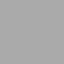

In [5]:
viewer = LavaVuModelViewer()
xyz = data[['X','Y','Z']]
vector = strike_dip_vector(data['strike'],data['dip'])
viewer.add_vector_data(xyz,vector,name='all_data')
viewer.interactive()

The data points are now randomly ordered and can now be subsampled by choosing the first N samples from the dataframe
```Python
data[:100]
```
returns the first 100 data points from the array

### Testing data density
* Use the toggle bar to change the amount of data used by the interpolation algorithm. 
* How does the shape of the fold change as we remove data points?
* Now what happens if we only consider data from the map view?

**HINT** you can view the strike and dip data by unchecking the scalar field box. 

**The black arrows are the normal vector to the folded surface**


In [6]:
@interact_manual(npoints=(1,200,10))
def run(npoints):
    model = GeologicalModel(boundary_points[0,:],boundary_points[1,:])
    model.set_model_data(data[:npoints])
    stratigraphy = model.create_and_add_foliation("s0",interpolatortype="PLI",nelements=5000,buffer=0.3,cgw=0.1)#.2)
    viewer = LavaVuModelViewer(model,background="white")
    # viewer.add_scalar_field(model.bounding_box,(38,55,30),
    #                       'box',
    #                      paint_with=stratigraphy,
    #                      cmap='prism')
    viewer.add_data(stratigraphy['feature'])
    viewer.add_isosurface(stratigraphy['feature'],
                         voxet=model.voxet())
    viewer.interactive()

interactive(children=(IntSlider(value=91, description='npoints', max=200, min=1, step=10), Button(description=…

### Modelling folds using structural geology

The following section will describe how the fold axis, fold axial surface and fold vergence can be used to help constrain the shape of the folded surface.
To do this we need to build a fold frame which is curvilinear coordinate system based around the fold axis and the fold axial surface. 

There are three coordinates to the fold frame:
* coordinate 0 is the axial surface of the fold and is parallel to the axial foliation
* coordinate 1 is the fold axis direction field and is orthogonal to the axial foliation
* coordinate 2 is orthogonal to both the fold axis direction field and axial foliation and is roughly parallel to the extension direction of the fold 

<img src="images/fold_frame.png" alt="Fold Frame" style="width: 400px;"/>

Three direction vectors are defined by the normalised gradient of these fields:
* $e_0$ - red
* $e_1$ - green
* $e_2$ - blue

The orientation of the folded foliation can be defined by rotating $e_1$ around $e_0$ by the fold axis rotation angle $\alpha_P$ to give the orientation of the fold axis. The orientation of the folded foliation can then be defined by rotating the plane defined by the fold axis and $e_0$ around the fold axis by the fold limb rotation angle $\alpha_L$. 

<img src="images/fold_constraints.png" alt="Fold constraints" style="width: 400px;"/>

### Calculating the fold rotation angles
The rotation angles can be calculated for observations of the folded foliation and assocaited lineations. For example, the fold axis rotation angle is found by calculating the angle between the gradient of the fold axis direction field and the intersection lineations shown in A). The fold limb rotation angle is found by finding the the angle to rotate the folded foliation to be parallel to the plane of the axial foliation shown in B and C. 
<img src="./images/fold_rotation_angles.png" alt="Fold rotation angles" style="width: 400px;"/>

In [7]:
@interact_manual(npoints=(5,200,1))
def run(npoints=10):
    mdata = pd.concat([data[:npoints],data[data['type']=='s1']])
    model = GeologicalModel(boundary_points[0,:],boundary_points[1,:])
    model.set_model_data(mdata)
    fold_frame = model.create_and_add_fold_frame('s1',
                                                 interpolatortype='PLI',
                                                 nelements=10000,buffer=0.5,
                                                 solver='pyamg',
                                                damp=True
                                                )
    stratigraphy = model.create_and_add_folded_foliation('s0',
                                                   fold_frame['feature'],
                                                    nelements=10000,
                                                   fold_axis=[-6.51626577e-06, -5.00013645e-01, -8.66017526e-01],
    #                                                    limb_wl=1
                                                         buffer=0.5
                                                        )
    viewer = LavaVuModelViewer(model,background="white")
    # viewer.add_scalar_field(model.bounding_box,(38,55,30),
    #                       'box',
    #                      paint_with=stratigraphy,
    #                      cmap='prism')
    viewer.add_isosurface(fold_frame['feature'][0],
                          colour='blue',
    #                       isovalue=0.4,
                          alpha=0.5)
    viewer.add_data(stratigraphy['feature'])
    viewer.add_isosurface(fold_frame['feature'][1],colour='green',alpha=0.5)
    # viewer.add_vector_field(fold_frame['feature'][0],locations=fold_frame['feature'][0].get_interpolator().support.barycentre())
    viewer.add_data(fold_frame['feature'][1])

    # viewer.add_data(stratigraphy['feature'])
    viewer.add_isosurface(stratigraphy['feature'])
    viewer.interactive()
    plt.plot(stratigraphy['foliation'],stratigraphy['limb_rotation'],'bo')
    x = np.linspace(fold_frame['feature'][0].min(),fold_frame['feature'][1].max(),100)
    plt.plot(x,stratigraphy['fold'].fold_limb_rotation(x),'r--')

interactive(children=(IntSlider(value=10, description='npoints', max=200, min=5), Button(description='Run Inte…

Now try changing the fold axis and see how this changes the S-Plot. 

In [9]:
@interact_manual(npoints=(5,200,1),plunge=(0,90,1),trend=(0,360,1))
def run(npoints=10,plunge=45,trend=0):
    axis = plunge_and_plunge_dir_to_vector(plunge,trend)   
    mdata = pd.concat([data[:npoints],data[data['type']=='s1']])
    model = GeologicalModel(boundary_points[0,:],boundary_points[1,:])
    model.set_model_data(mdata)
    fold_frame = model.create_and_add_fold_frame('s1',
                                                 interpolatortype='PLI',
                                                 nelements=10000,buffer=0.5,
                                                 solver='pyamg',
                                                damp=True
                                                )
    stratigraphy = model.create_and_add_folded_foliation('s0',
                                                   fold_frame['feature'],
                                                    nelements=10000,
                                                   fold_axis=axis,#[-6.51626577e-06, -5.00013645e-01, -8.66017526e-01],
    #                                                    limb_wl=1
                                                         solver='pyamg',
                                                         buffer=0.5
                                                        )
    viewer = LavaVuModelViewer(model,background="white")
    # viewer.add_scalar_field(model.bounding_box,(38,55,30),
    #                       'box',
    #                      paint_with=stratigraphy,
    #                      cmap='prism')
    viewer.add_isosurface(fold_frame['feature'][0],
                          colour='blue',
    #                       isovalue=0.4,
                          alpha=0.5)
    viewer.add_data(stratigraphy['feature'])
    viewer.add_isosurface(fold_frame['feature'][1],colour='green',alpha=0.5)
    # viewer.add_vector_field(fold_frame['feature'][0],locations=fold_frame['feature'][0].get_interpolator().support.barycentre())
    viewer.add_data(fold_frame['feature'][1])
    viewer.add_fold(stratigraphy['fold'],locations=model.regular_grid()[::30])
    # viewer.add_data(stratigraphy['feature'])
    viewer.add_isosurface(stratigraphy['feature'])
    viewer.interactive()
    plt.plot(stratigraphy['foliation'],stratigraphy['limb_rotation'],'bo')
    x = np.linspace(fold_frame['feature'][0].min(),fold_frame['feature'][1].max(),100)
    plt.plot(x,stratigraphy['fold'].fold_limb_rotation(x),'r--')

interactive(children=(IntSlider(value=10, description='npoints', max=200, min=5), IntSlider(value=45, descript…

### Evaluation
Do you think that a typical structural map and cross section has enough data to be able to constrain the geometry of folds in 3D?

